In [1]:
import scipy.io as sio
import numpy as np
from copy import deepcopy
from scipy.optimize import minimize
from matplotlib import pyplot as plt
from scipy.special import erf
from mpl_toolkits.mplot3d import Axes3D
from qcels import ham_shift
import cmath
import matplotlib
#import hubbard_1d
#import quspin
#import fejer_kernel
#import fourier_filter
#import generate_cdf
#from qcels import *
matplotlib.rcParams['font.size'] = 15
matplotlib.rcParams['lines.markersize'] = 10
# T_Sim (Theoretical Simulation), Q_Sim (Quantum Simulation), Q_Real (Quantum Hardware)
data_name  = 'Q_Sim'

In [2]:
def plot_QCELS(model, sites):
    #-------------Load data-------
    QCELS_result=np.load('Data/'+data_name+'_result_'+str(model)+'_'+str(sites)+'sites_QCELS.npz')

    rate_success_QCELS=QCELS_result['name1']
    cost_list_avg_QCELS=QCELS_result['name2']
    err_QCELS=QCELS_result['name3']
    est_QCELS=QCELS_result['name4']
    re_gs=QCELS_result['name5'] 
    probs=QCELS_result['name6']
    n_probs = len(probs)

    #------------Plot data----------------
    print('QCELS')
    print(rate_success_QCELS)

    plt.figure(figsize=(12,10))

    for i in range(n_probs):
        plt.plot(cost_list_avg_QCELS[i,:],err_QCELS[i,:],linestyle="-.",marker="o",label="Error of QCELS p_0="+str(probs[i]))

    plt.xlabel("Total Shots",fontsize=35)
    plt.ylabel("error($ϵ$)",fontsize=35) 
    plt.title('Error vs Runtime '+str(model))

    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)

    plt.xscale("log")
    plt.yscale("log")

    plt.legend(fontsize=25)
    plt.savefig('Graphs/'+data_name+'_'+str(model)+'_cost_'+str(sites)+'.pdf')

    plt.figure(figsize=(12,10))

    for i in range(n_probs):
        plt.plot(cost_list_avg_QCELS[i,:],est_QCELS[i,:],linestyle="-.",marker="o",label="Estimate of QCELS p_0="+str(probs[i]))

    plt.plot(cost_list_avg_QCELS[0,:], np.zeros(len(est_QCELS[0,:])) + re_gs, label='Ground State')

    plt.xlabel("Total Shots",fontsize=35)
    plt.ylabel("Estimate",fontsize=35) 
    plt.title('Estimate Convergence '+str(model))

    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)
    
    #plt.xscale("log")
    #plt.yscale("log")

    plt.legend(fontsize=25)
    plt.savefig('Graphs/'+data_name+'_'+str(model)+'_conv_'+str(sites)+'.pdf')
    plt.show()

QCELS
[[0. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1.]]


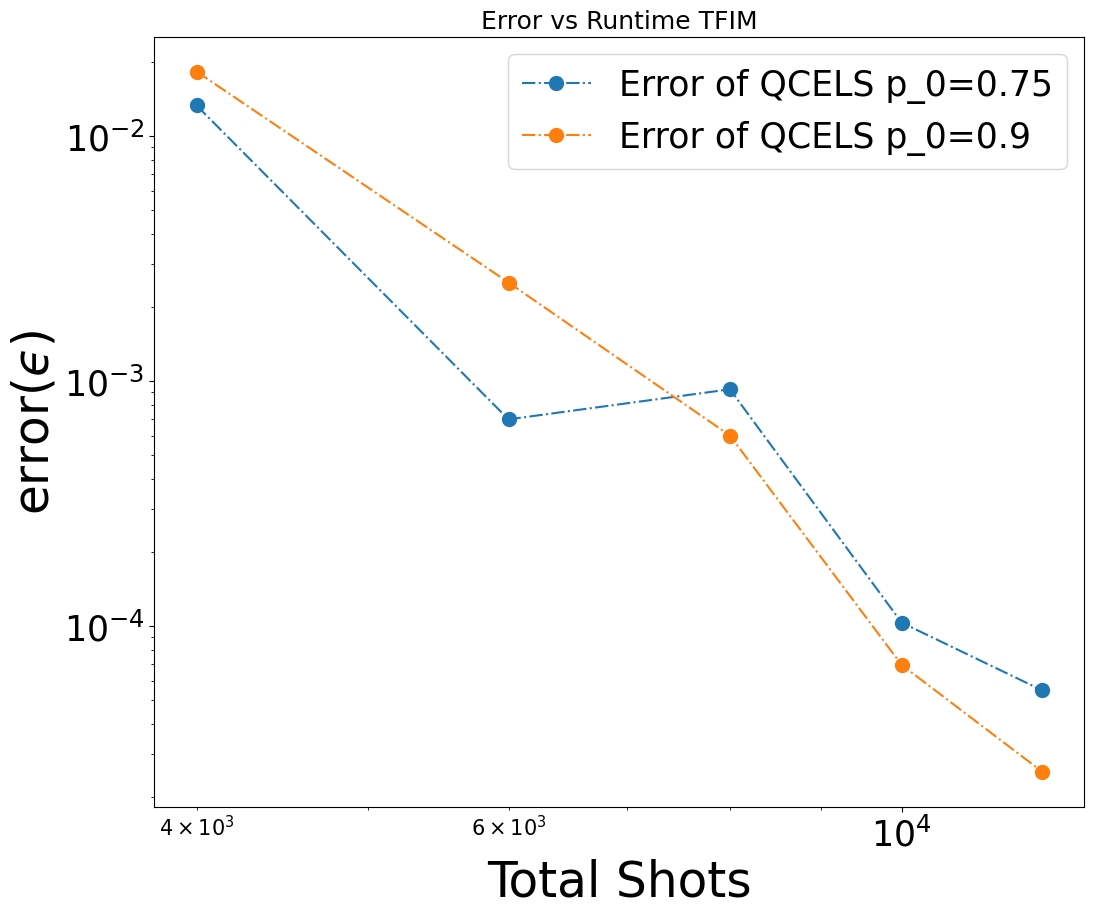

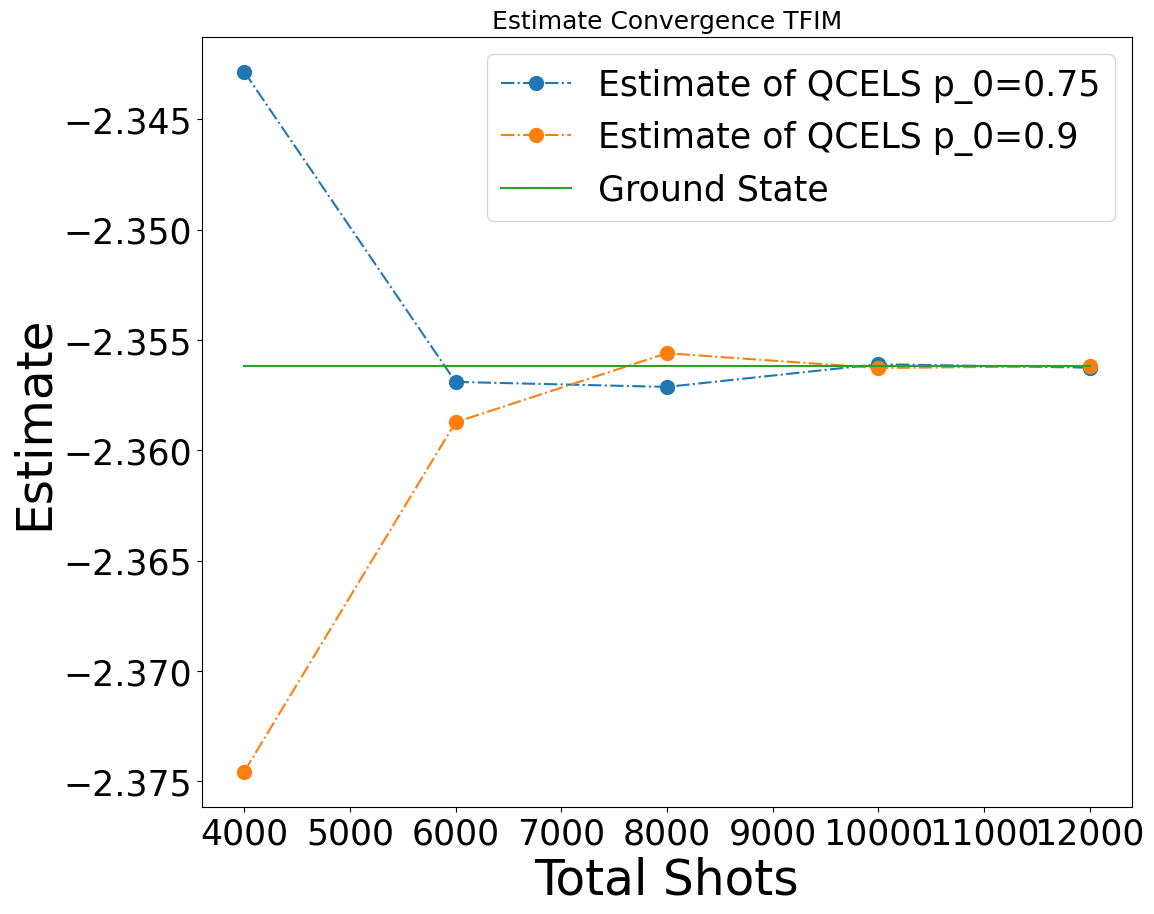

In [3]:
#-------------Graph for TFIM_4sites---
plot_QCELS('TFIM', 2)

QCELS
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


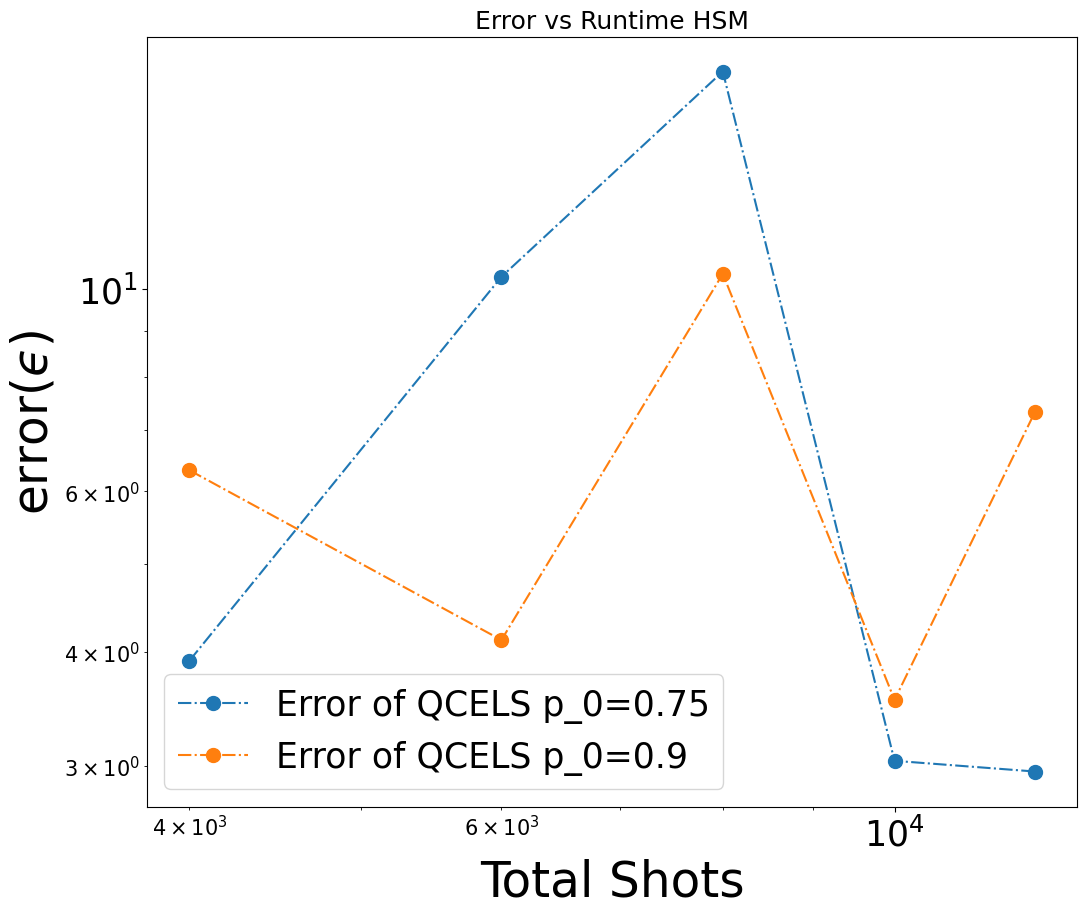

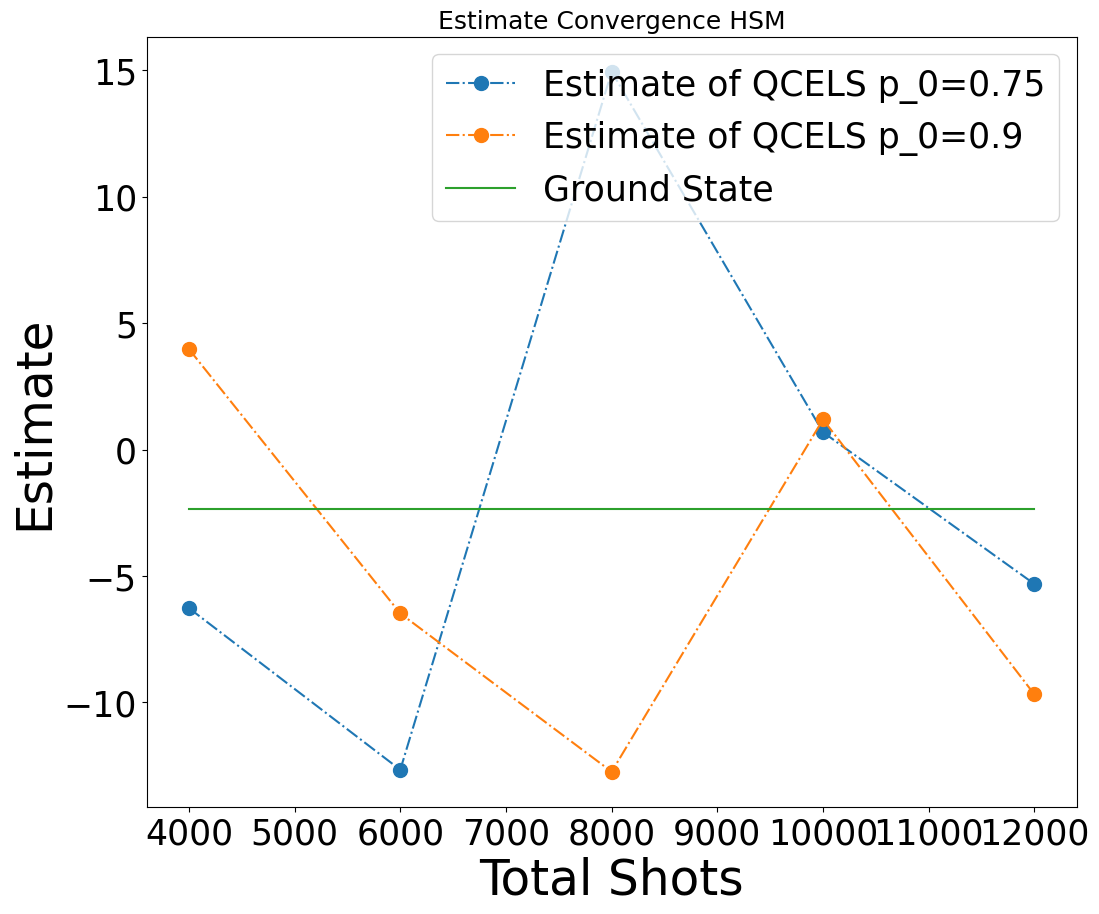

In [6]:
#-------------Graph for HSM_4sites---
plot_QCELS('HSM', 3)

QCELS
[[0. 0. 0. 1. 1.]
 [0. 0. 0. 1. 1.]]


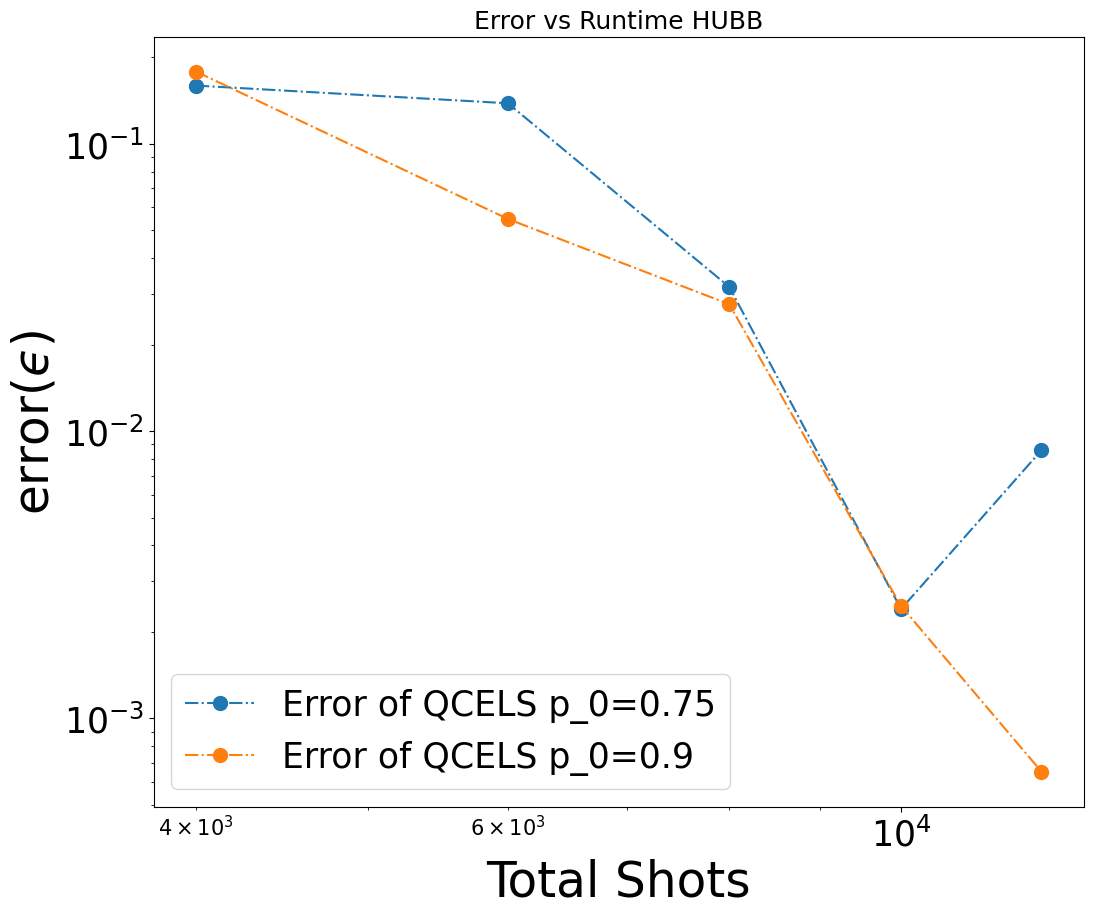

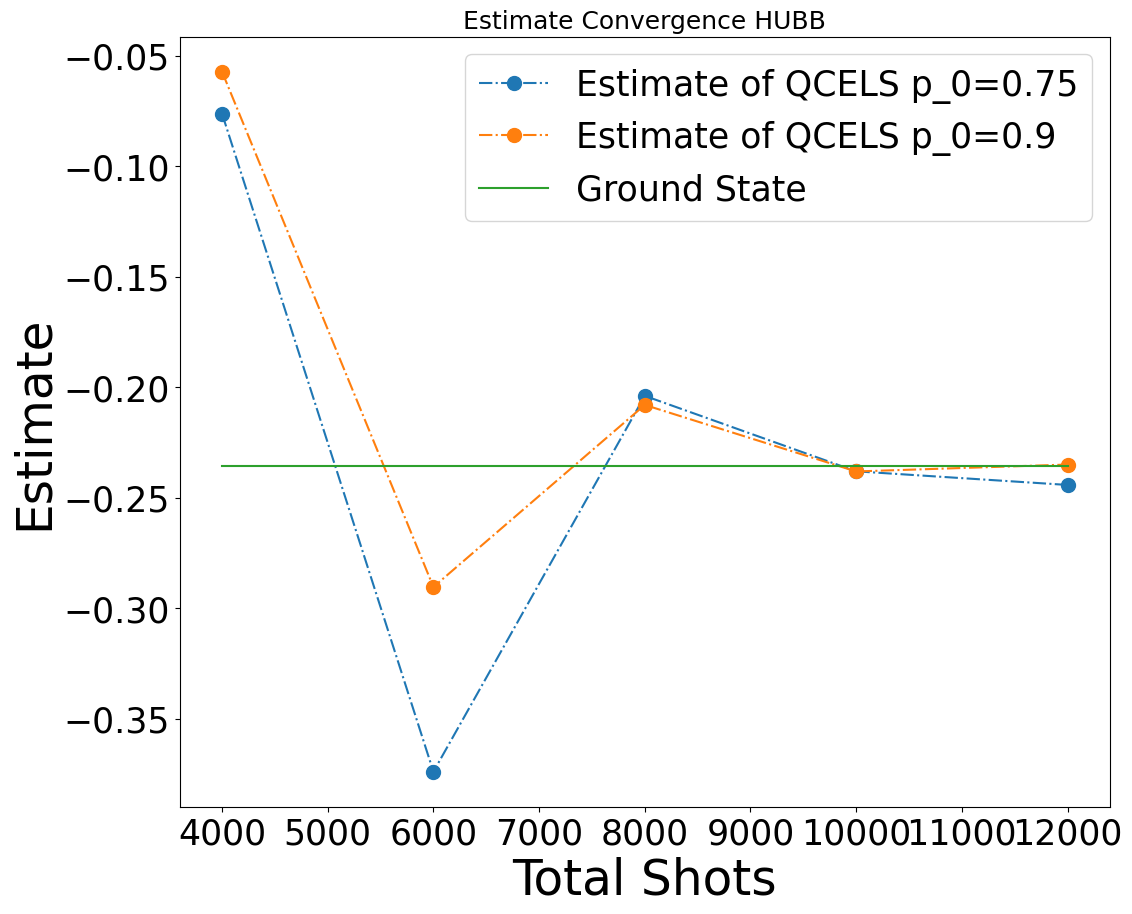

In [7]:
#-------------Graph for TFIM_4sites---
plot_QCELS('HUBB', 2)

QCELS
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


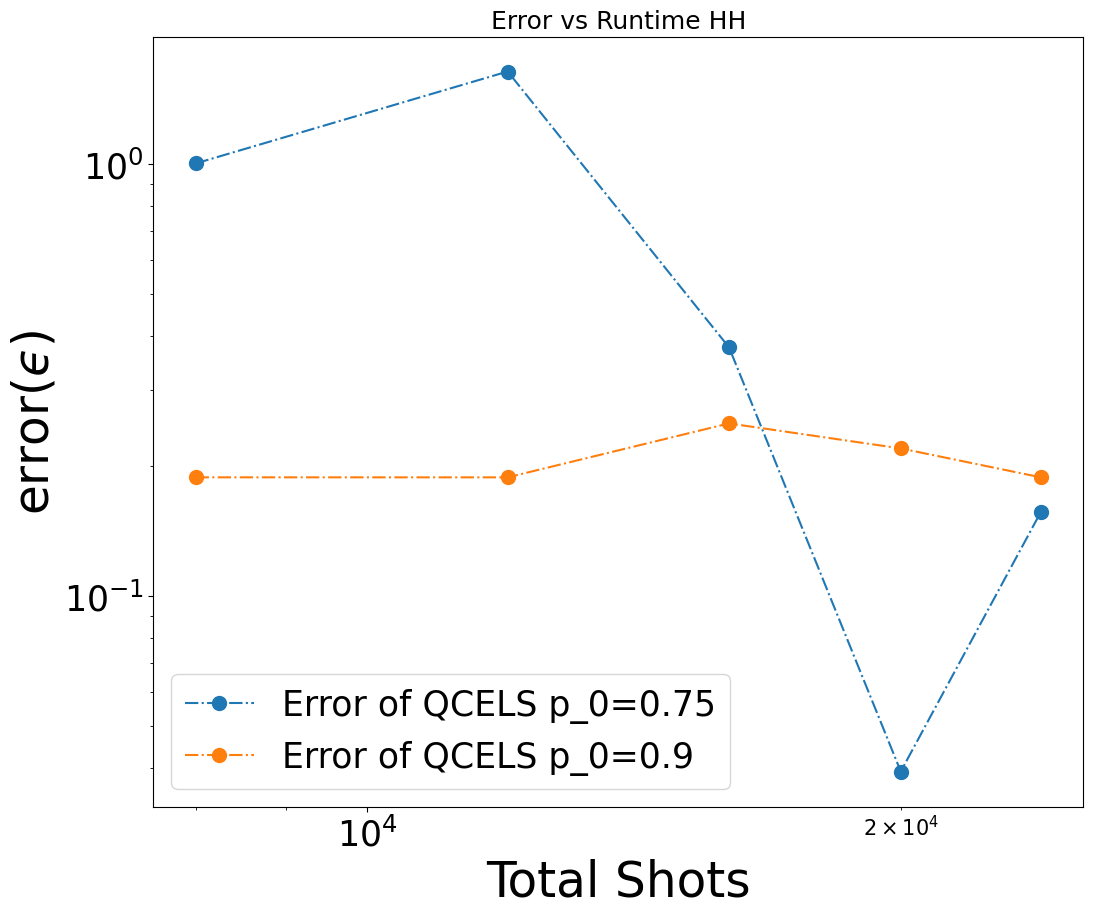

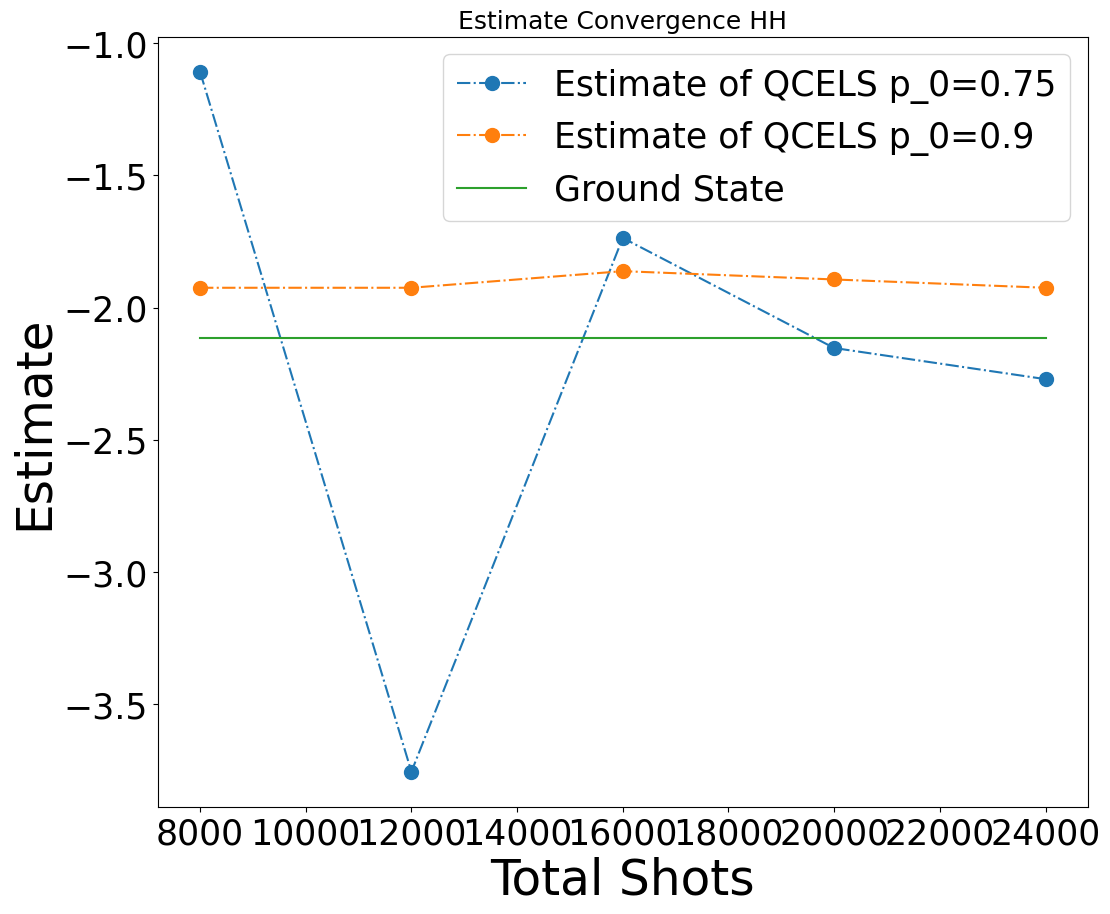

In [12]:
#-------------Graph for HH---
plot_QCELS('HH', 1)

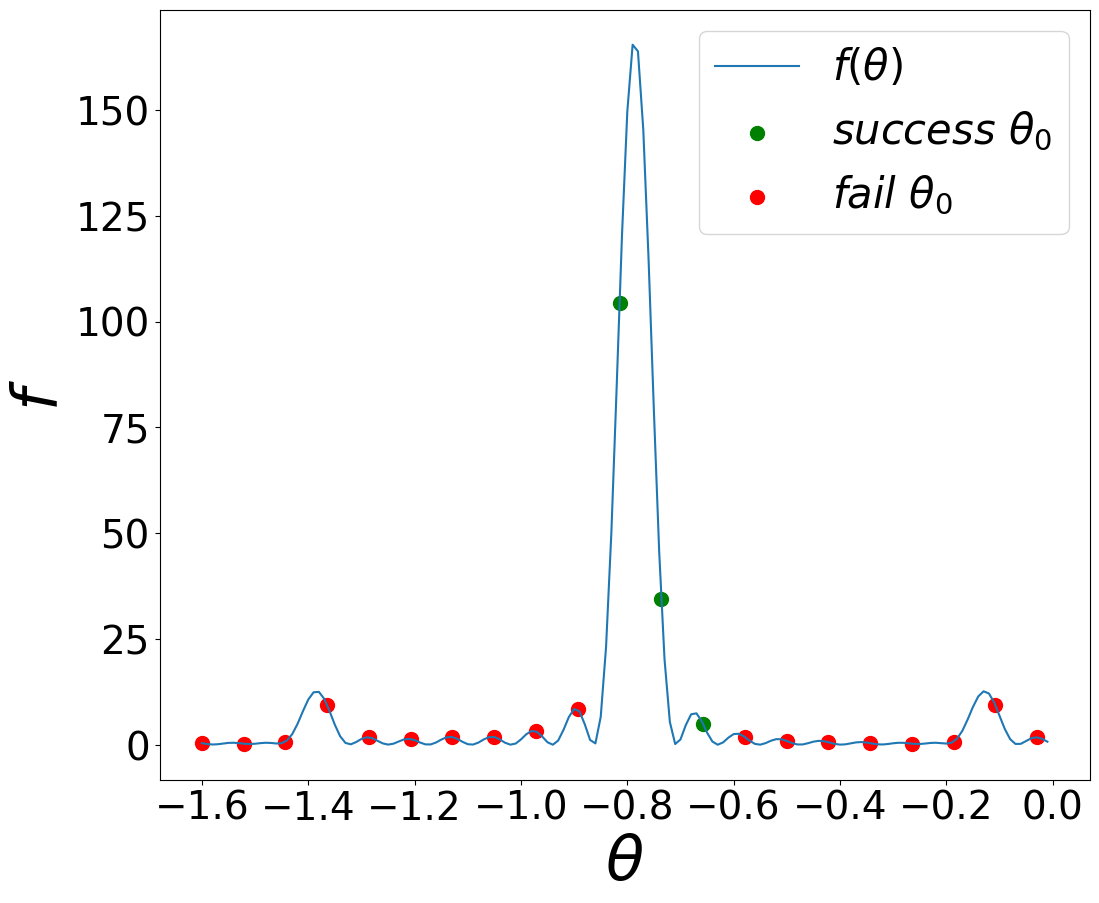

In [ ]:
### loss function
TFIM_data=np.load('Data/'+data_name+'_TFIM_8sites_data.npz')
spectrum=TFIM_data['name1']
population=TFIM_data['name2']
tau=5
NT=16
T=tau*NT
x=-1.6+np.arange(int(1.6/0.01))*(0.01)
z=-1.6+np.arange(int(1.6/(2*np.pi/T))+1)*(2*np.pi/T)
sf=np.zeros(len(z))
ts=tau*np.arange(NT)
Error=np.zeros(len(x),dtype = 'complex128')
Error_z=np.zeros(len(z),dtype = 'complex128')
for i in range(len(x)):
    for j in range(NT):
         Error[i]=Error[i]+np.dot(population,np.exp(-1j*(spectrum-x[i])*ts[j]))
for i in range(len(z)):
    for j in range(NT):
         Error_z[i]=Error_z[i]+np.dot(population,np.exp(-1j*(spectrum-z[i])*ts[j]))      
###------define function---------
def fun(x):
        signal=0
        for j in range(NT):
             signal=signal+np.dot(population,np.exp(-1j*(spectrum-x)*ts[j]))
        return (-abs(signal)**2)
##-------True minimizer---------
x0=spectrum[0]
min_z=minimize(fun,x0)
#--------solve minimization problem for different initial guess--------
for i in range(len(z)):
    x0=z[i]
    res=minimize(fun,x0)
    if abs(res.x[0]-min_z.x[0])<0.01:
        sf[i]=1
fig=plt.figure(figsize=(12,10))
plt.plot(x,abs(Error)**2,label=r"$f(\theta)$")
plt.scatter(z[np.where(sf==1)],abs(Error_z[np.where(sf==1)])**2,label=r"$success\ \theta_0$",c ="green")
plt.scatter(z[np.where(sf==0)],abs(Error_z[np.where(sf==0)])**2,label=r"$fail\ \theta_0$",c ="red")
plt.xlabel(r"$\theta$",fontsize=45)
plt.ylabel(r"$f$",fontsize=45) 
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.legend(fontsize=30)
plt.savefig('Graphs/'+data_name+'_Loss_landscape.pdf')

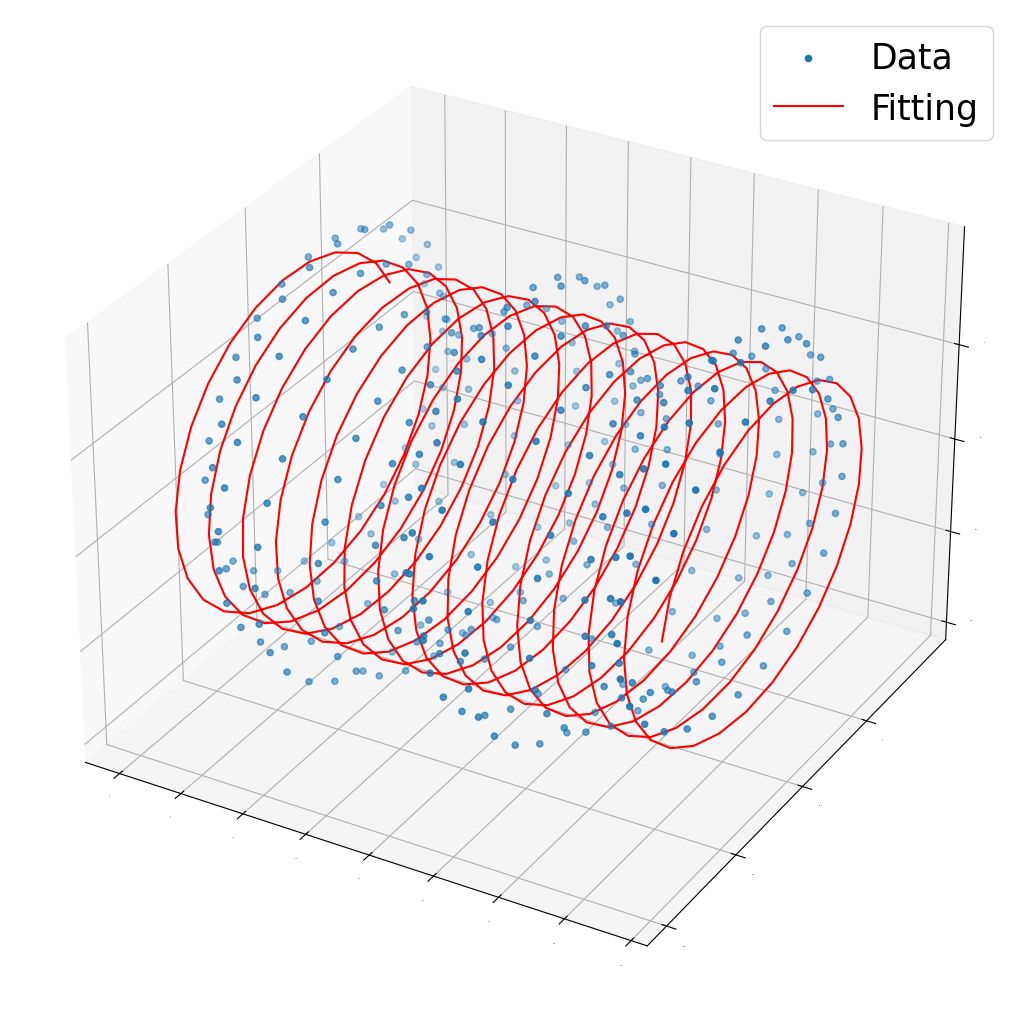

In [19]:
### Signal comparison for TFIM model
TFIM_data=np.load('Data/'+data_name+'_TFIM_8sites_data.npz')
spectrum=TFIM_data['name1']
population=TFIM_data['name2']
x0=TFIM_data['name3']
x1=TFIM_data['name4']
x2=TFIM_data['name5']
tau=0.1
NT=int(sum(cost_list_avg_QCELS[0,:]))
ts=tau*np.arange(NT)
Re_approx=np.zeros(NT)
Im_approx=np.zeros(NT)
Re_true=np.zeros(NT)
Im_true=np.zeros(NT)
for i in range(NT):
    signal=(x0+1j*x1)*np.exp(-1j*x2*ts[i]) #Fitting function
    Re_approx[i]=signal.real
    Im_approx[i]=signal.imag
    Solu=np.dot(population,np.exp(-1j*spectrum*ts[i])) #Signal function
    Re_true[i]=Solu.real
    Im_true[i]=Solu.imag
fig=plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection="3d")
ax.set_position([0, 0, 0.95, 1])
ax.scatter3D(ts,Re_true,Im_true,label="Data")
ax.plot3D(ts,Re_approx,Im_approx,label="Fitting",color='red')
ax.set_zticks(np.arange(-1, 1, 0.5))
ax.tick_params(axis='z',labelsize=0)
ax.set_yticks(np.arange(-1, 1, 0.5))
ax.tick_params(axis='y',labelsize=0)
ax.tick_params(axis='x',labelsize=0)
#  ax.set_zlabel('Imaginary part',fontsize=30,labelpad=20) 
#  ax.set_ylabel('Real part',fontsize=30,labelpad=20) 
#  ax.set_xlabel('Time t',fontsize=30,labelpad=20) 
plt.legend(fontsize=25)
plt.savefig('Graphs/'+data_name+'_Fitting.pdf')

In [ ]:
# #-------------Graph for Hubbard_4sites---
# #-------------Load data-------
# QPE_result=np.load('result_hubbard_4sites_QPE.npz')
# QCELS_result=np.load('result_hubbard_4sites_QCELS.npz')
# rate_success_QPE=QPE_result['name1']
# T_list_QPE=QPE_result['name2']
# cost_list_avg_QPE=QPE_result['name3']
# err_QPE=QPE_result['name4']
# rate_success_QCELS=QCELS_result['name1']
# max_T_QCELS=QCELS_result['name2']
# cost_list_avg_QCELS=QCELS_result['name3']
# err_QCELS=QCELS_result['name4']
# rel_overlap=QCELS_result['name5']
# #------------Plot data----------------
# print('QCELS')
# print(rate_success_QCELS)
# print('QPE')
# print(rate_success_QPE)    
# plt.figure(figsize=(12,10))
# plt.plot(max_T_QCELS[0,:],err_QCELS[0,:],linestyle="-.",marker="o",
#          label=data_type+" error of QCELS p_0=0.4, p_r={}".format(rel_overlap[0]))
# plt.plot(T_list_QPE,err_QPE[0,:],linestyle="-.",marker="*",
#          label=data_type+" error of QPE p_0=0.4")
# plt.plot(max_T_QCELS[1,:],err_QCELS[1,:],linestyle="-.",marker="o",
#          label=data_type+" error of QCELS p_0=0.1, p_r={}".format(rel_overlap[1]))
# plt.plot(T_list_QPE,err_QPE[1,:],linestyle="-.",marker="*",
#          label=data_type+" error of QPE p_0=0.1")
# plt.plot(max_T_QCELS[0,:],0.06*np.pi/max_T_QCELS[0,:],linestyle="-",color="grey",label="$0.06/T$ scaling")
# plt.plot(T_list_QPE,6*np.pi/T_list_QPE,linestyle="-",color="grey",label="$6\pi/T$ scaling")
# plt.xlabel("$T_{max}$",fontsize=35)
# plt.ylabel("error($ϵ$)",fontsize=35)
# plt.xticks(fontsize=25)
# plt.yticks(fontsize=25)
# plt.xscale("log")
# plt.yscale("log")
# plt.ylim(top=10)
# plt.legend(fontsize=20)
# plt.savefig('Graphs/Hubbard_depth_4.pdf')
# plt.figure(figsize=(12,10))
# plt.plot(cost_list_avg_QCELS[0,:],err_QCELS[0,:],linestyle="-.",marker="o",
#          label=data_type+" error of QCELS p_0=0.4, p_r={}".format(rel_overlap[0]))
# plt.plot(cost_list_avg_QPE[0,:],err_QPE[0,:],linestyle="-.",marker="*",
#          label=data_type+" error of QPE p_0=0.4")
# plt.plot(cost_list_avg_QCELS[1,:],err_QCELS[1,:],linestyle="-.",marker="o",
#          label=data_type+" error of QCELS p_0=0.1, p_r={}".format(rel_overlap[1]))
# plt.plot(cost_list_avg_QPE[1,:],err_QPE[1,:],linestyle="-.",marker="*",
#          label=data_type+" error of QPE p_0=0.1")
# plt.xlabel("$T_{total}$",fontsize=35)
# plt.ylabel("error($ϵ$)",fontsize=35) 
# plt.xticks(fontsize=25)
# plt.yticks(fontsize=25)
# plt.xscale("log")
# plt.yscale("log")
# plt.ylim(top=10)
# plt.legend(fontsize=23)
# plt.savefig('Graphs/Hubbard_cost_4.pdf')
# plt.show()

In [3]:
# #-------------Graph for Hubbard_8sites---
# #-------------Load data-------
# QPE_result=np.load('result_hubbard_8sites_QPE.npz')
# QCELS_result=np.load('result_hubbard_8sites_QCELS.npz')
# rate_success_QPE=QPE_result['name1']
# T_list_QPE=QPE_result['name2']
# cost_list_avg_QPE=QPE_result['name3']
# err_QPE=QPE_result['name4']
# rate_success_QCELS=QCELS_result['name1']
# max_T_QCELS=QCELS_result['name2']
# cost_list_avg_QCELS=QCELS_result['name3']
# err_QCELS=QCELS_result['name4']
# rel_overlap=QCELS_result['name5']
# #------------Plot data----------------
# print('QCELS')
# print(rate_success_QCELS)
# print('QPE')
# print(rate_success_QPE)    
# plt.figure(figsize=(12,10))
# plt.plot(max_T_QCELS[0,:],err_QCELS[0,:],linestyle="-.",marker="o",
#          label=data_type+" error of QCELS p_0=0.4, p_r={}".format(rel_overlap[0]))
# plt.plot(T_list_QPE,err_QPE[0,:],linestyle="-.",marker="*",
#          label=data_type+" error of QPE p_0=0.4")
# plt.plot(max_T_QCELS[1,:],err_QCELS[1,:],linestyle="-.",marker="o",
#          label=data_type+" error of QCELS p_0=0.1, p_r={}".format(rel_overlap[1]))
# plt.plot(T_list_QPE,err_QPE[1,:],linestyle="-.",marker="*",
#          label=data_type+" error of QPE p_0=0.1")
# plt.plot(max_T_QCELS[0,:],0.08*np.pi/max_T_QCELS[0,:],linestyle="-",color="grey",label="$0.08\pi/T$ scaling")
# plt.plot(T_list_QPE,6*np.pi/T_list_QPE,linestyle="-",color="grey",label="$6\pi/T$ scaling")
# plt.xlabel("$T_{max}$",fontsize=35)
# plt.ylabel("error($ϵ$)",fontsize=35)
# plt.xticks(fontsize=25)
# plt.yticks(fontsize=25)
# plt.xscale("log")
# plt.yscale("log")
# plt.ylim(top=1)
# plt.legend(fontsize=20)
# plt.savefig('Graphs/Hubbard_depth_8.pdf')
# plt.figure(figsize=(12,10))
# plt.plot(cost_list_avg_QCELS[0,:],err_QCELS[0,:],linestyle="-.",marker="o",
#          label=data_type+" error of QCELS p_0=0.4, p_r={}".format(rel_overlap[0]))
# plt.plot(cost_list_avg_QPE[0,:],err_QPE[0,:],linestyle="-.",marker="*",
#          label=data_type+" error of QPE p_0=0.4")
# plt.plot(cost_list_avg_QCELS[1,:],err_QCELS[1,:],linestyle="-.",marker="o",
#          label=data_type+" error of QCELS p_0=0.1, p_r={}".format(rel_overlap[1]))
# plt.plot(cost_list_avg_QPE[1,:],err_QPE[1,:],linestyle="-.",marker="*",
#         label=data_type+" error of QPE p_0=0.1")
# plt.xlabel("$T_{total}$",fontsize=35)
# plt.ylabel("error($ϵ$)",fontsize=35) 
# plt.xticks(fontsize=25)
# plt.yticks(fontsize=25)
# plt.xscale("log")
# plt.yscale("log")
# plt.ylim(top=1)
# plt.legend(fontsize=25)
# plt.savefig('Graphs/Hubbard_cost_8.pdf')
# plt.show()

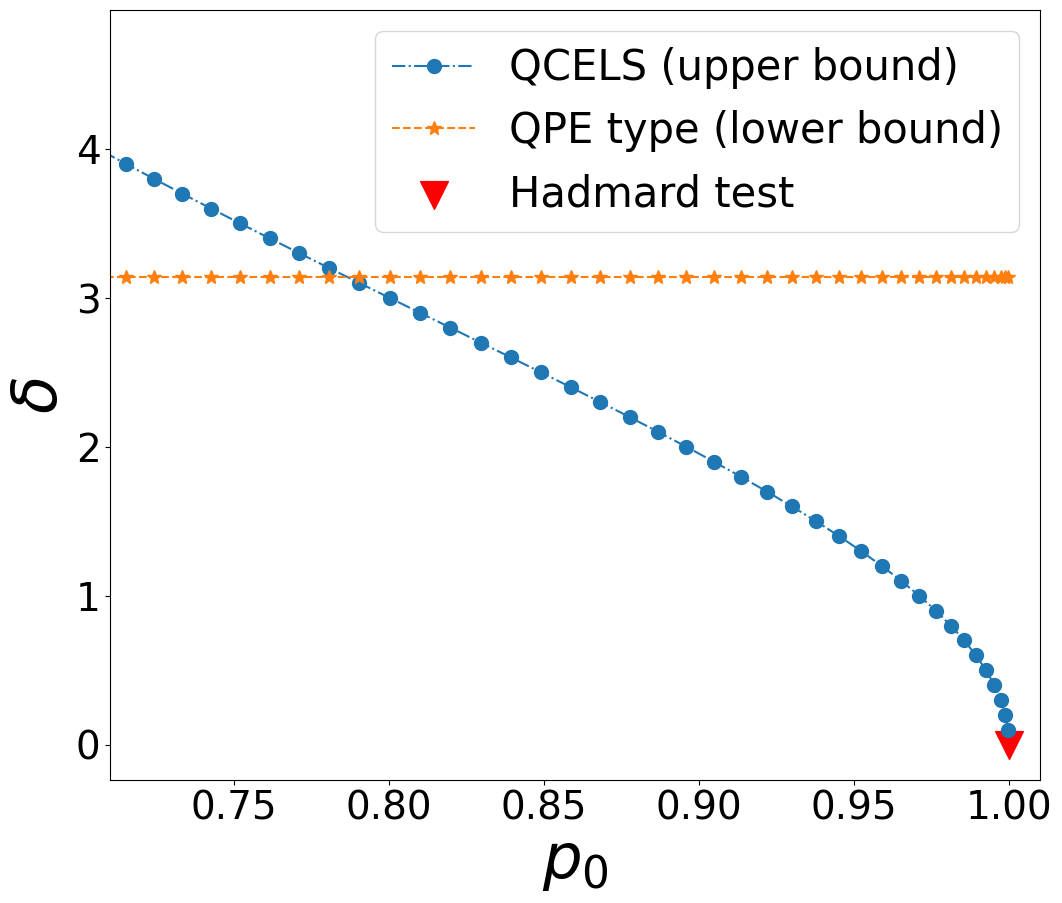

In [ ]:
####---------Depth_theory-------------------
x=0.1+0.1*np.arange(int(1.5*np.pi/0.1))
alpha=1.217 #constant \alpha
d=np.zeros(len(x))
for n in range(len(x)):
    a=x[n]*np.cos(x[n]/10)/(2*np.sin(x[n]/2))
    d[n]=a*alpha/((1+alpha)*a-1)
plt.figure(figsize=(12,10))
plt.plot(d,x,linestyle="-.",marker="o",label="QCELS (upper bound)")
plt.plot(d,np.pi*np.ones(len(d)),linestyle="--",marker="*",label="QPE type (lower bound)")
plt.scatter(1,0,marker="v",s=400,label='Hadmard test',c ="red")
plt.xlim([0.71,1.01])
plt.xlabel("$p_0$",fontsize=45)
plt.ylabel("$\delta$",fontsize=45) 
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.legend(fontsize=30)
plt.savefig('Graphs/'+data_name+'_Depth_theory.pdf')